## Definitions & Imports

In [2]:
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt

from IPython.display import display, Math,Markdown

In [3]:
## Custom functions
import FermionSystem as fst
import KitaevTools as kt

## Additional Functions

In [5]:
%load_ext cython

In [6]:
%%cython
## For speed, using cython here to define the hamiltonian function utilised
## by the sparse solver. 
## Should be placed inside the FermionSystem file but did not yet look up 
## how to generate the c code and use it inside the python file
## TO DO: pass the rows and columns and generate function after H is extracted
## rather than re-passing the same rows/cols data every time
import numpy as np
cimport numpy as cnp

def hamiltonian_matvec(
    cnp.ndarray[double, ndim=1] x,
    cnp.ndarray[int, ndim=1] rows,
    cnp.ndarray[int, ndim=1] cols,
    cnp.ndarray[double, ndim=1] vals
):
    cdef int r, c, i
    cdef double v
    cdef cnp.ndarray[double, ndim=1] result = np.zeros_like(x)
    cdef int n = rows.shape[0]

    for i in range(n):
        r = rows[i]
        c = cols[i]
        v = vals[i]
        result[r] += v * x[c]
        result[c] += v * x[r]

    return result

Content of stdout:
_cython_magic_76bb88c6bc04f84a628c95ec6998ecadcbedc2df.c
C:\Users\btenhaaf\AppData\Local\anaconda3\envs\Kitaev3_2DEG\lib\site-packages\numpy\core\include\numpy\npy_1_7_deprecated_api.h(14) : Warning Msg: Using deprecated NumPy API, disable it with #define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION
C:\Users\btenhaaf\.ipython\cython\_cython_magic_76bb88c6bc04f84a628c95ec6998ecadcbedc2df.c(4565): warning C4244: '=': conversion from 'npy_intp' to 'int', possible loss of data
   Creating library C:\Users\btenhaaf\.ipython\cython\Users\btenhaaf\.ipython\cython\_cython_magic_76bb88c6bc04f84a628c95ec6998ecadcbedc2df.cp39-win_amd64.lib and object C:\Users\btenhaaf\.ipython\cython\Users\btenhaaf\.ipython\cython\_cython_magic_76bb88c6bc04f84a628c95ec6998ecadcbedc2df.cp39-win_amd64.exp
Generating code
Finished generating code

# Basic Functions

## States and Operators

In [7]:
## FermionSystem provides functions for acting with 'operators' on Fock states using binary operations
## where both states and operators are represented by integers.
## Requires specifying the number of fermionic sites N:
N = 2
fs = fst.FermionSystem(N)

## Each integer represents a fock state in binary, where each site covers two bits (00 = 0, 01 = down, 10 = up, 11 = up+down)
fs.vis_state(1,displ=True)
fs.vis_state(2,displ=True)
fs.vis_state(3,displ=True)
fs.vis_state(0B100,displ=True)
fs.vis_state(0B111,displ=True)
fs.vis_state(0B1111,displ=True)

## The size of the system N is only relevant for the logic related to the operators
## Integers exceeding the largest possible state still just exist, but
## an operator acting on it will only be able to act on the first N sites
fs.vis_state(2000, displ=True)

|↓,0〉

|↑,0〉

|↓↑,0〉

|0,↓〉

|↓↑,↓〉

|↓↑,↓↑〉

|0,0,↓,↓↑,↓↑,↓〉

In [8]:
## Operators are similarly represented by integers, storing the position on the fock state to act on 
## + a bit specifying if the operator is creation or annihilation. 
## The largest bit sets the purpose, such that creation operators are always larger numbers than annihilation operators (for sorting in normal order)

# operator to create a spin up in site 1:
operator = fs.operator('creation',1,'up')
display(Markdown(f'Created operator {fs.vis_oper(operator)}, represented by the number: {operator}'))

Created operator $c^{†}_{1,↑}$, represented by the number: 7

In [9]:
fs = fst.FermionSystem(4)
## Return the operators that represent a state:
state = 0B101101
opers = fs.state_to_oper_list(state)
fs.vis_oper_list(opers,displ=True)

$c^{†}_{2,↑}$$c^{†}_{1,↑}$$c^{†}_{1,↓}$$c^{†}_{0,↓}$

In [10]:
fs = fst.FermionSystem(4)
## Given two states, return the operator sequence and sign to go from one to the other:
state_1 = 10
state_2 = 20
oper,sign = fs.state_to_state(state_1,state_2)
display(Markdown(f'{"-" if sign <0 else ""}{fs.vis_oper_list(oper)}{fs.vis_state(state_1)} = {fs.vis_state(state_2)}'))

-$c^{†}_{2,↓}$$c^{†}_{1,↓}$$c_{1,↑}$$c_{0,↑}$|↑,↑,0,0〉 = |0,↓,↓,0〉

## Acting on states

In [11]:
# The action of operators on fock states is handled by 'act_oper', returning the new states and the signs
operator = fs.operator('creation',1,'up')
state = 0B111

new_state,sign = fs.act_oper(operator, np.array([state]))
display(Markdown(f'{fs.vis_oper(operator)}{fs.vis_state(state)} = {"-" if sign[0] ==-1 else ""}{fs.vis_state(new_state[0])}'))

$c^{†}_{1,↑}$|↓↑,↓,0,0〉 = -|↓↑,↓↑,0,0〉

In [12]:
# A sequence of operators is represented as a list of ints
# Applying the sequence to states uses fs.act_oper_list, which returns only states that are not destroyed by the sequence
fs = fst.FermionSystem(N=3)

oper_1 = fs.operator('creation',0,'up')
oper_2 = fs.operator('creation',1,'up')
CAR_up_up = [oper_1,oper_2]

## Here: applying the CAR operator to the list of all possible Fock states
old_states,new_states,signs = fs.act_oper_list(CAR_up_up, fs.fock_states)

## Show results of the operation
display(Markdown(f"Non-zero terms for operator {fs.vis_oper_list(CAR_up_up,displ=False)}"))
for state,new_state,parity in zip(old_states,new_states,signs):
    if parity == 1:
        display(Markdown(f"{fs.vis_oper_list(CAR_up_up)}{fs.vis_state(state)} = {fs.vis_state(new_state)}"))
    else:
        display(Markdown(f"{fs.vis_oper_list(CAR_up_up)}{fs.vis_state(state)} = -{fs.vis_state(new_state)}"))

Non-zero terms for operator $c^{†}_{1,↑}$$c^{†}_{0,↑}$

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,0,0〉 = -|↑,↑,0〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,0,0〉 = -|↓↑,↑,0〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,↓,0〉 = |↑,↓↑,0〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,↓,0〉 = |↓↑,↓↑,0〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,0,↓〉 = -|↑,↑,↓〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,0,↓〉 = -|↓↑,↑,↓〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,↓,↓〉 = |↑,↓↑,↓〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,↓,↓〉 = |↓↑,↓↑,↓〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,0,↑〉 = -|↑,↑,↑〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,0,↑〉 = -|↓↑,↑,↑〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,↓,↑〉 = |↑,↓↑,↑〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,↓,↑〉 = |↓↑,↓↑,↑〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,0,↓↑〉 = -|↑,↑,↓↑〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,0,↓↑〉 = -|↓↑,↑,↓↑〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|0,↓,↓↑〉 = |↑,↓↑,↓↑〉

$c^{†}_{1,↑}$$c^{†}_{0,↑}$|↓,↓,↓↑〉 = |↓↑,↓↑,↓↑〉

## Normal Ordering

In [13]:
## Normal ordering of the states requires sorting the list of operators (integers) in size 
## This is now done with a bubble sort, which straightforwardly allows tracking the number of swaps

fs = fst.FermionSystem(N=3)

## Example of an non-ordered list of operators:
oper_list = [fs.operator('creation',2,'down'), fs.operator('creation',1,'up'),fs.operator('annihilation',0,'down'),fs.operator('creation',1,'down')]
display(Markdown(f'Original sequence: {fs.vis_oper_list(oper_list)} ({oper_list})'))

## Retrieving the list in order + the sign
normal_ordered,sign = fs.normal_order(oper_list)
display(Markdown(f'Normal order: {"-" if sign < 1 else ""}{fs.vis_oper_list(normal_ordered)} ({normal_ordered})'))

Original sequence: $c^{†}_{1,↓}$$c_{0,↓}$$c^{†}_{1,↑}$$c^{†}_{2,↓}$ ([12, 11, 0, 10])

Normal order: -$c^{†}_{2,↓}$$c^{†}_{1,↑}$$c^{†}_{1,↓}$$c_{0,↓}$ ([0, 10, 11, 12])

# Example: Kitaev Chain

## Constructing and solving system

In [14]:
# An additional class (ParitySystem) is relevant for cases where a division of the fock states 
# into odd and even parity sectors is desired (i.e.: the Kitaev chain)
N=2

## Dictionary with all relevant parameters
## Parameter names used here are arbitrary, a function is required to link them to the correct 'operators' ('map_H_params_Kitaev' in this case)
H_params = {
    'd_dd': [0]*(N-1),'d_uu': [0]*(N-1),'d_ud': [20]*(N-1),'d_du': [20]*(N-1),
    't_dd': [20]*(N-1),'t_uu': [20]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}
fs = fst.FermionSystem(N)

## Generate a list of all relevant operators for the Kitaev chain (with interactions)
## This is just a list with lists of integers representing the operator sequences
generate_kitaev_hamiltonian = partial(kt.make_kitaev_hamiltonian,fs)

## Links operators to understandable parameter names
generate_mapping = partial(kt.map_H_params_kitaev,fs,H_params)

## Create a ParitySystem (builds on FermionSystem): seperates the fock states into odd and even parity states 
## and applies the provided Hamiltonian to calculate non-zero terms for later use
chain = fst.ParitySystem(N = N, H_generator=generate_kitaev_hamiltonian,H_mapping = generate_mapping, Ez_inf = False, U_inf=True, sparse_function = hamiltonian_matvec)

## Once chain is constructed, can use solve_system to get eigenvalues and eigenvector
## Two methods are included:
## 'linalg' -> uses numpy's linalg.eigh, requires constructing the matrix
## 'sparse' -> uses scipy's LinearOperator class, does not require explicitly filling a matrix
##             returns the lowest N eigenvalues and eigenvectors (set by 'n_values')
##             The method is faster for N>4, if only a small number of eigenvalues are needed
E_odd,E_even, phi_odd,phi_even = chain.solve_system(method='sparse', n_values=1)
E_odd,E_even, phi_odd,phi_even = chain.solve_system(method='linalg')
print(f"Odd ground state energy: {E_odd[0]}")
print(f"Odd ground state: {chain.vis_state_list(chain.odd_states,phi_odd[0])}\n")
print(f"Even ground state energy: {E_even[0]}")
print(f"Even ground state: {chain.vis_state_list(chain.even_states,phi_even[0])}\n")

Odd ground state energy: -20.0
Odd ground state: -0.707|↓,0〉+0.707|0,↓〉

Even ground state energy: -28.284271247461902
Even ground state: +0.707|0,0〉-0.5|↑,↓〉-0.5|↓,↑〉



In [15]:
## To show all eigenstates and solutions:
chain = kt.make_kitaev_chain(2, H_params, Ez_inf = False, U_inf=True) # shortcut for the Kitaev chain construction
chain.eigenstates(only_ground_states=False,only_energies=False)

(ground) (even)      E = -28.28     |φ〉= +0.707|0,0〉-0.5|↑,↓〉-0.5|↓,↑〉
(excited) (odd)      E = -20.00     |φ〉= -0.707|↓,0〉+0.707|0,↓〉
(excited) (odd)      E = -20.00     |φ〉= +0.707|↑,0〉-0.707|0,↑〉
(excited) (even)     E = 0.00       |φ〉= -1.0|↓,↓〉
(excited) (even)     E = 0.00       |φ〉= +1.0|↑,↑〉
(excited) (even)     E = 0.00       |φ〉= -0.707|↑,↓〉+0.707|↓,↑〉
(excited) (odd)      E = 20.00      |φ〉= +0.707|↑,0〉+0.707|0,↑〉
(excited) (odd)      E = 20.00      |φ〉= -0.707|↓,0〉-0.707|0,↓〉
(excited) (even)     E = 28.28      |φ〉= +0.707|0,0〉+0.5|↑,↓〉+0.5|↓,↑〉


Basis: |↓,0〉, |↑,0〉, |0,↓〉, |0,↑〉


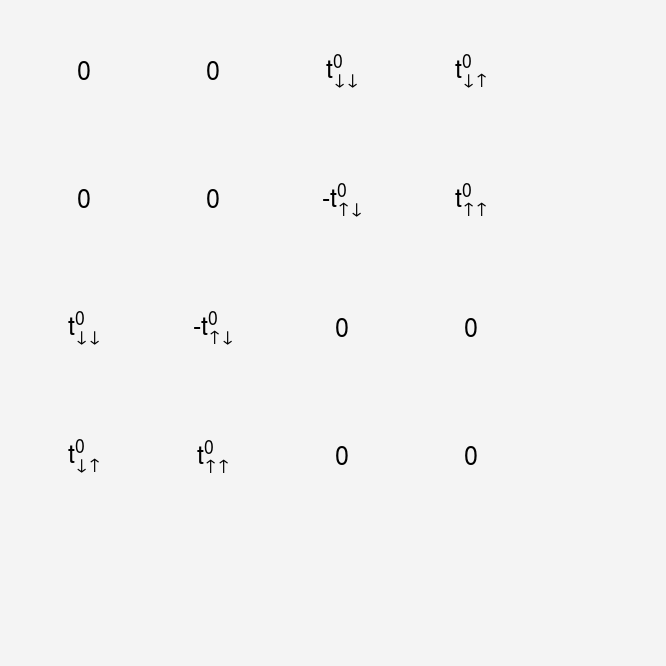

In [16]:
## For small Hamiltonians and debugging: print a symbolic Hamiltonian
chain.show_hamiltonian(parity = 'odd')

Basis: |↓,0〉, |↑,0〉, |0,↓〉, |0,↑〉


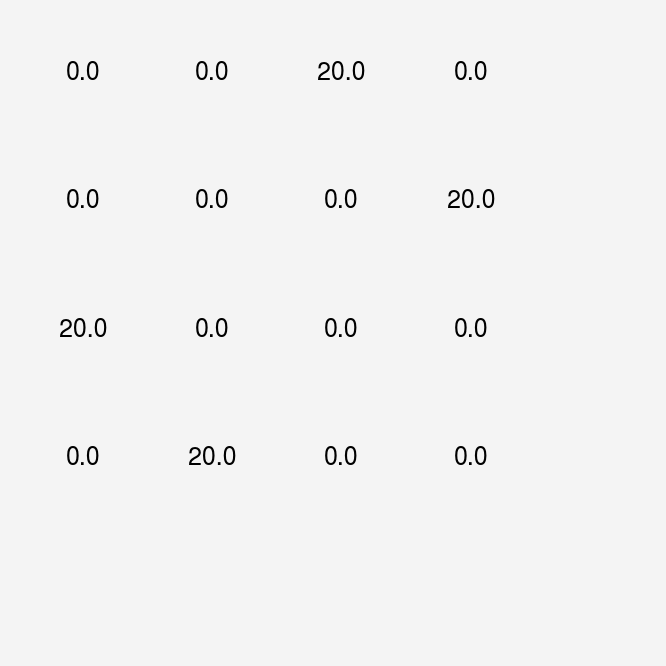

In [17]:
## For small Hamiltonians/debugging: print the filled matrix
chain.show_hamiltonian(parity = 'odd', numeric=True)

## Energy Spectrum 

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 163.40it/s]


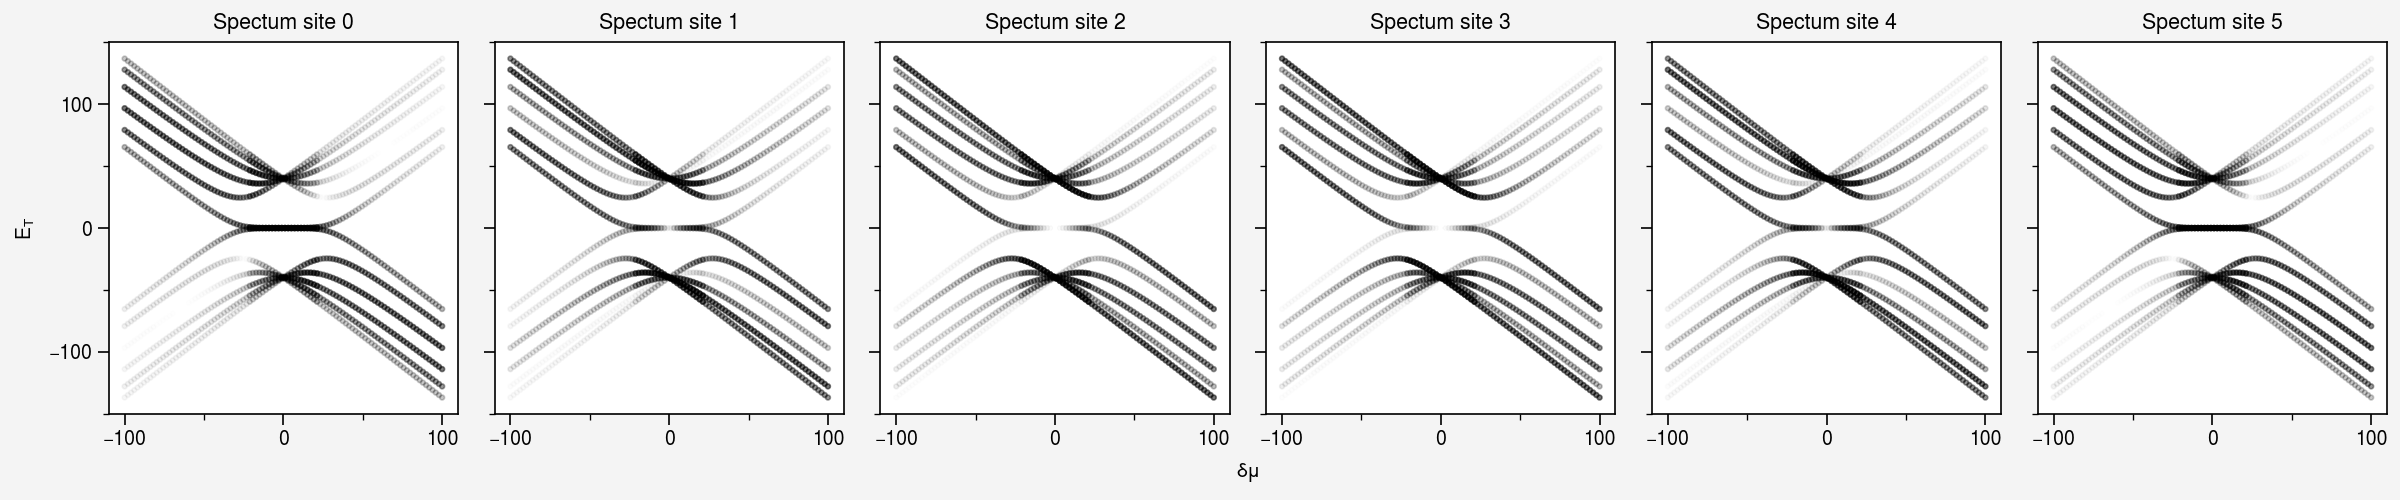

In [18]:
## To calculate an energy spectrum (for comparing to finite bias conductace measurements)
## the function'energy_spectrum' extracts all the transitions and probablities for transitions 
## between even and odd ground states

N = 6

## Create Figure
fig, ax = pplt.subplots(np.arange(N)+1, figwidth = N*2, figheight = 2.5, grid='off')
fig.format(ylim = [-150,150])
fig.format(xlabel = '$\delta \mu$', xlocator=100,xminorlocator=50, ylocator=100,yminorlocator=50)

## Set parameters
H_params = {
    'd_dd': [20]*(N-1),'d_uu': [20]*(N-1),'d_ud': [0]*(N-1),'d_du': [0]*(N-1),
    't_dd': [20]*(N-1),'t_uu': [20]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}

## Create chain
chain = kt.make_kitaev_chain(N,H_params, Ez_inf=True,U_inf=True, make_arrays=True, sparse_function =hamiltonian_matvec)

## Range and parameters to vary 
mu_range = np.linspace(-100,100,100)
vary_params =  [f'mu_d_{i}' for i in range(chain.N) ] # All mu_down parameters int he chain

## PLot energy spectrum for all sites
timed =0
for i in range(N):
    kt.energy_spectrum(chain, vary_params, mu_range, i, fig, ax[i], plot=True)

## Odd-Even Phase Space

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.53it/s]


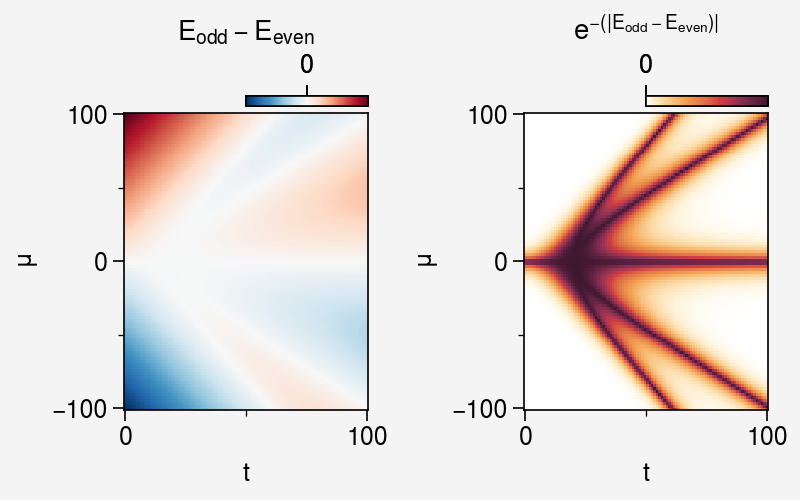

In [19]:
## To map out the parity of the ground state of the system as a function of differen parameters
## the 'phase_space' function is included
## The default setting now uses the 'sparse' method to calculate the phase space, which becomes 
## more efficient for N > 4 (also at some point memory becomes in issue for storing the
## entire matrix)


fig,axs = pplt.subplots([1,2],figwidth = 4,figheight=2.5, sharex=False,sharey=False)
fig.format(xlabel = '$t$', ylabel = '$\mu$', xlocator=100,xminorlocator=50,ylocator=100,yminorlocator=50)

## Set up a Kitaev chain
N=5
H_params = {
    'd_dd': [20]*(N-1),'d_uu': [20]*(N-1),'d_ud': [0]*(N-1),'d_du': [0]*(N-1),
    't_dd': [40]*(N-1),'t_uu': [40]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
    'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
}
chain = kt.make_kitaev_chain(N,H_params, Ez_inf=True,U_inf=True, make_arrays=False,sparse_function = hamiltonian_matvec)


## Select parameters and ranges
mu_range = np.linspace(-100,100,100)
t_range = np.linspace(0,100,100)

## Instruct to vary all mu parameters and all t parameters
vary_mu = [f'mu_d_{i}' for i in range(N)] + [f'mu_u_{i}' for i in range(N)]
vary_t = [f't_uu_{i}' for i in range(N-1)] + [f't_dd_{i}' for i in range(N-1)] 

## Calculate energy differences
results = kt.phase_space(chain,vary_t,t_range, vary_mu, mu_range,T=4)

## Plot E_odd - E_even 
im = axs[0].pcolormesh(t_range,mu_range, results[0], levels=500)
axs[0].colorbar(im, width=0.05, length = 0.5, pad=0,loc='top',align='right')
axs[0].format(title = '$E_{odd} - E_{even}$')

## Plot e^(|E_odd-E_even|)
im = axs[1].pcolormesh(t_range,mu_range, results[1], levels=500)
axs[1].colorbar(im, width=0.05, length = 0.5, pad=0, loc='top', align='right')
axs[1].format(title = '$e^{-(|E_{odd} - E_{even})|}$')



In [ ]:
## Generate grid to calculate phase space as a function of N
array = [[1,2,3],[4,5,6],[7,8,9]]
fig,axs = pplt.subplots(array,figwidth = 5.5,figheight=5.5, sharex=False,sharey=False)
fig.format(xlabel = '$t$', ylabel = '$\mu$', xlocator=100,xminorlocator=50,ylocator=100,yminorlocator=50)

N_range = np.arange(2,11)
for idx,N in enumerate(N_range):
    ax = axs[idx]
    H_params = {
        'd_dd': [20]*(N-1),'d_uu': [20]*(N-1),'d_ud': [0]*(N-1),'d_du': [0]*(N-1),
        't_dd': [40]*(N-1),'t_uu': [40]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
        'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
    }
    
    chain = kt.make_kitaev_chain(N,H_params, Ez_inf=True,U_inf=True, make_arrays=False,sparse_function = hamiltonian_matvec)
    
    mu_range = np.linspace(-100,100,50)
    t_range = np.linspace(-100,100,50)

    vary_mu = [f'mu_d_{i}' for i in range(N)] + [f'mu_u_{i}' for i in range(N)]
    vary_t = [f't_uu_{i}' for i in range(N-1)] + [f't_dd_{i}' for i in range(N-1)] 
    
    results = kt.phase_space(chain,vary_t,t_range, vary_mu, mu_range,)[1]
    
    ax.pcolormesh(t_range,mu_range, results, levels=500)
    ax.format(title = f'N = {N}')


 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:03<00:03,  6.79it/s]

In [ ]:
## Generate grid to calculate phase space as a function of N
## Here for a spinful system (does get a bit time consuming after N>7)

array = [[1,2,3],[4,5,6]]
fig,axs = pplt.subplots(array,figwidth = 5.5,figheight=3.6,sharex=False,sharey=False)
fig.format(xlabel = '$t$', ylabel = '$\mu$', xlocator=100,xminorlocator=50,ylocator=100,yminorlocator=50)

N_range = np.arange(2,8)
for idx,N in enumerate(N_range):
    ax = axs[idx]
    H_params = {
        'd_dd': [0]*(N-1),'d_uu': [0]*(N-1),'d_ud': [20]*(N-1),'d_du': [20]*(N-1),
        't_dd': [20]*(N-1),'t_uu': [20]*(N-1),'t_ud': [0]*(N-1),'t_du': [0]*(N-1),
        'mu': [0]*N,'Ez': [0]*N,'U': [0]*N,
    }
    
    chain = kt.make_kitaev_chain(N,H_params, Ez_inf=False,U_inf=True, make_arrays=False,sparse_function = hamiltonian_matvec)
    
    mu_range = np.linspace(-100,100,50)
    t_range = np.linspace(-100,100,50)
    vary_mu = [f'mu_d_{i}' for i in range(N)] + [f'mu_u_{i}' for i in range(N)]
    vary_t = [f't_uu_{i}' for i in range(N-1)] + [f't_dd_{i}' for i in range(N-1)] 
    
    results = kt.phase_space(chain,vary_t,t_range, vary_mu, mu_range,)[1]
     
    ax.pcolormesh(t_range,mu_range, results, levels=500)
    ax.format(title = f'N = {N}')